In [1]:
# 0) Install / imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random, os, sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1) Reproducibility seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# 2) Load CIFAR-10 and create train/val/test splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [5]:
# create 90% train / 10% val from original train
n_total = x_train.shape[0]  # 50000
idx = np.arange(n_total)
np.random.shuffle(idx)
val_count = int(0.1 * n_total)
val_idx = idx[:val_count]
train_idx = idx[val_count:]

x_val, y_val = x_train[val_idx], y_train[val_idx]
x_train_full, y_train_full = x_train[train_idx], y_train[train_idx]

print("Shapes -> train_full:", x_train_full.shape, "val:", x_val.shape, "test:", x_test.shape)

Shapes -> train_full: (45000, 32, 32, 3) val: (5000, 32, 32, 3) test: (10000, 32, 32, 3)


In [6]:
# 3) Create moderate imbalance: reduce classes 3(cat),4(deer),5(dog) to 20%
REDUCED_CLASSES = [3,4,5]
REDUCED_RATIO = 0.2

def make_moderate_imbalance(X, Y, reduced_classes=REDUCED_CLASSES, reduced_ratio=REDUCED_RATIO, seed=SEED):
    np.random.seed(seed)
    keep = []
    for c in range(10):
        cls_idx = np.where(Y == c)[0]
        if c in reduced_classes:
            n_keep = max(1, int(len(cls_idx) * reduced_ratio))
            chosen = np.random.choice(cls_idx, size=n_keep, replace=False).tolist()
        else:
            chosen = cls_idx.tolist()
        keep.extend(chosen)
    keep = np.array(keep)
    np.random.shuffle(keep)
    return X[keep], Y[keep]

x_train_bal, y_train_bal = x_train_full, y_train_full
x_train_imb, y_train_imb = make_moderate_imbalance(x_train_full, y_train_full)

def class_counts(y):
    return [int(np.sum(y==i)) for i in range(10)]

print("Balanced train counts:", class_counts(y_train_bal))
print("Imbalanced train counts:", class_counts(y_train_imb))
print("Val counts:", class_counts(y_val))
print("Test counts:", class_counts(y_test))

Balanced train counts: [4533, 4489, 4515, 4500, 4493, 4493, 4495, 4501, 4489, 4492]
Imbalanced train counts: [4533, 4489, 4515, 900, 898, 898, 4495, 4501, 4489, 4492]
Val counts: [467, 511, 485, 500, 507, 507, 505, 499, 511, 508]
Test counts: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [7]:
# 4) tf.data pipelines (with optional augmentation)
BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomCrop(32, 32)
], name="data_augmentation")

def make_ds(X, Y, batch=BATCH, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED)
    def _prep(x, y):
        x = tf.cast(x, tf.float32)
        if augment:
            x = data_augmentation(x)
        return x, y
    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_bal_ds = make_ds(x_train_bal, y_train_bal, augment=True)
train_imb_ds = make_ds(x_train_imb, y_train_imb, augment=True)
val_ds = make_ds(x_val, y_val, augment=False, shuffle=False)
test_ds = make_ds(x_test, y_test, augment=False, shuffle=False)

In [8]:
# 5) Tiny HLGA-style Keras model
# Note: uses a Lambda with tf.image.extract_patches; we avoid saving entire model - we only save weights
def build_tiny_hlga(input_shape=(32,32,3), num_classes=10):
    inp = layers.Input(shape=input_shape, name='input_image')

    # small CNN backbone
    x = layers.Conv2D(32, 3, padding='same', activation='relu', name='conv1')(inp)
    x = layers.MaxPool2D(2, name='pool1')(x)   # 16x16
    x = layers.Conv2D(64, 3, padding='same', activation='relu', name='conv2')(x)
    x = layers.MaxPool2D(2, name='pool2')(x)   # 8x8
    x = layers.Conv2D(128, 3, padding='same', activation='relu', name='conv3')(x)  # 8x8

    # extract non-overlapping 2x2 patches from (8x8) -> (4x4) patches => N=16
    patch_size = 2
    def _extract_patches(t):
        patches = tf.image.extract_patches(
            images=t,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        B = tf.shape(patches)[0]
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, (B, -1, patch_dim))  # (B, N, patch_dim)
        return patches

    patches = layers.Lambda(_extract_patches, name='patch_extractor')(x)  # (B, N, patch_dim)
    tokens = layers.Dense(128, activation='relu', name='patch_proj')(patches)  # (B,N,128)

    # simple token pooling (mean) as light-weight global modeling
    tokens_pool = layers.GlobalAveragePooling1D(name='token_pool')(tokens)   # (B,128)
    cnn_pool = layers.GlobalAveragePooling2D(name='cnn_pool')(x)            # (B,128)

    # fusion + classification head
    fused = layers.Concatenate(name='fusion')([tokens_pool, cnn_pool])      # (B,256)
    fused = layers.Dense(128, activation='relu', name='fusion_fc')(fused)
    fused = layers.Dropout(0.3)(fused)
    outputs = layers.Dense(num_classes, activation='softmax', name='classifier')(fused)

    model = keras.Model(inputs=inp, outputs=outputs, name='tiny_hlga_basic')
    return model

# quick summary
tmp_model = build_tiny_hlga()
tmp_model.summary()
del tmp_model
tf.keras.backend.clear_session()

Model: "tiny_hlga_basic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 16, 16,    │          0 │ conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 16, 16,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 8, 8, 64)  │          0 │ conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 8, 8, 128) │     73,856 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor     │ (None, None, 512) │          0 │ conv3[0][0]       │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_proj (Dense)  │ (None, None, 128) │     65,664 │ patch_extractor[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_pool          │ (None, 128)       │          0 │ patch_proj[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_pool            │ (None, 128)       │          0 │ conv3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion              │ (None, 256)       │          0 │ token_pool[0][0], │
│ (Concatenate)       │                   │            │ cnn_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_fc (Dense)   │ (None, 128)       │     32,896 │ fusion[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ fusion_fc[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 10)        │      1,290 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 193,098 (754.29 KB)

 Trainable params: 193,098 (754.29 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 6) Helper: compute class weights (robust, using keyword args)
def get_class_weights(y):
    classes = np.unique(y)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return {int(c): float(w) for c, w in zip(classes, cw)}

cw_imb = get_class_weights(y_train_imb)
print("Class weights for imbalanced train:", cw_imb)

Class weights for imbalanced train: {0: 0.7546878446944628, 1: 0.762085096903542, 2: 0.7576965669988925, 3: 3.801111111111111, 4: 3.809576837416481, 5: 3.809576837416481, 6: 0.7610678531701891, 7: 0.7600533214841146, 8: 0.762085096903542, 9: 0.7615761353517364}


In [10]:
# 7) Training helper that saves weights only (avoids Lambda serialization errors)
def compile_and_train(model, train_ds, val_ds, class_weights=None, epochs=12, lr=1e-3, weight_path=None):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    callbacks = []
    if weight_path:
        # NOTE: when save_weights_only=True, filename must end with .weights.h5
        callbacks.append(keras.callbacks.ModelCheckpoint(weight_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy'))
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weights, callbacks=callbacks, verbose=2)
    if weight_path:
        model.load_weights(weight_path)
    return model, history

In [11]:
# 8) Evaluate helper (collect labels robustly)
def evaluate_on_test(model, test_dataset):
    y_true = []
    y_pred = []
    for Xb, yb in test_dataset:
        preds = model.predict(Xb, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1).tolist())
        y_true.extend(yb.numpy().tolist())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "f1":f1, "prec":prec, "rec":rec, "cm":cm}


=== TRAIN: Balanced dataset (demo, 8 epochs) ===
Epoch 1/8
352/352 - 28s - 80ms/step - accuracy: 0.2800 - loss: 1.8824 - val_accuracy: 0.3706 - val_loss: 1.6691
Epoch 2/8
352/352 - 17s - 47ms/step - accuracy: 0.4214 - loss: 1.5466 - val_accuracy: 0.4884 - val_loss: 1.3854
Epoch 3/8
352/352 - 18s - 52ms/step - accuracy: 0.4851 - loss: 1.3954 - val_accuracy: 0.5492 - val_loss: 1.2388
Epoch 4/8
352/352 - 18s - 50ms/step - accuracy: 0.5343 - loss: 1.2810 - val_accuracy: 0.5426 - val_loss: 1.2462
Epoch 5/8
352/352 - 20s - 58ms/step - accuracy: 0.5651 - loss: 1.2097 - val_accuracy: 0.6016 - val_loss: 1.1467
Epoch 6/8
352/352 - 17s - 49ms/step - accuracy: 0.5922 - loss: 1.1367 - val_accuracy: 0.6080 - val_loss: 1.0996
Epoch 7/8
352/352 - 18s - 50ms/step - accuracy: 0.6146 - loss: 1.0713 - val_accuracy: 0.6526 - val_loss: 0.9884
Epoch 8/8
352/352 - 17s - 50ms/step - accuracy: 0.6336 - loss: 1.0266 - val_accuracy: 0.6372 - val_loss: 1.0272

=== EVAL: Balanced model on Test ===
Balanced Test Ac

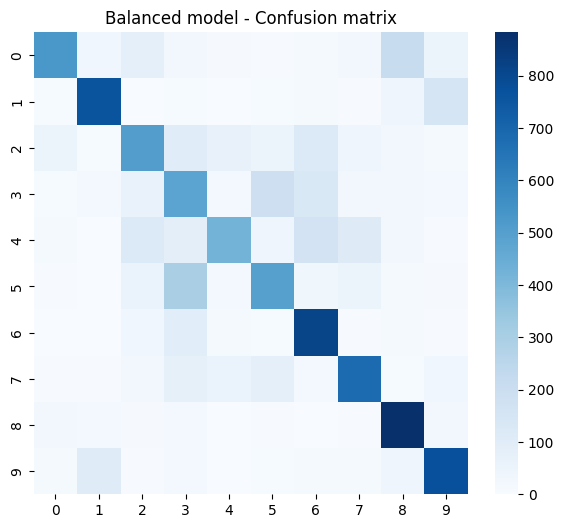

In [12]:
# 9) Train & evaluate (short demo runs) - Balanced
print("\n=== TRAIN: Balanced dataset (demo, 8 epochs) ===")
tf.keras.backend.clear_session()
model_bal = build_tiny_hlga()
model_bal, hist_bal = compile_and_train(model_bal, train_bal_ds, val_ds, class_weights=None, epochs=8, lr=1e-3, weight_path='balanced_model.weights.h5')

print("\n=== EVAL: Balanced model on Test ===")
res_bal = evaluate_on_test(model_bal, test_ds)
print("Balanced Test Acc: {:.4f}, F1: {:.4f}".format(res_bal['acc'], res_bal['f1']))
plt.figure(figsize=(7,6)); sns.heatmap(res_bal['cm'], cmap='Blues'); plt.title('Balanced model - Confusion matrix'); plt.show()


=== TRAIN: Imbalanced dataset (demo, 8 epochs) ===
Epoch 1/8
268/268 - 22s - 82ms/step - accuracy: 0.2810 - loss: 1.9682 - val_accuracy: 0.3350 - val_loss: 1.7228
Epoch 2/8
268/268 - 13s - 50ms/step - accuracy: 0.4246 - loss: 1.6407 - val_accuracy: 0.4448 - val_loss: 1.4899
Epoch 3/8
268/268 - 14s - 52ms/step - accuracy: 0.4920 - loss: 1.4906 - val_accuracy: 0.4830 - val_loss: 1.3966
Epoch 4/8
268/268 - 20s - 75ms/step - accuracy: 0.5393 - loss: 1.3806 - val_accuracy: 0.5330 - val_loss: 1.2536
Epoch 5/8
268/268 - 14s - 51ms/step - accuracy: 0.5732 - loss: 1.3137 - val_accuracy: 0.5578 - val_loss: 1.2138
Epoch 6/8
268/268 - 15s - 55ms/step - accuracy: 0.5987 - loss: 1.2458 - val_accuracy: 0.5806 - val_loss: 1.1518
Epoch 7/8
268/268 - 14s - 51ms/step - accuracy: 0.6220 - loss: 1.1828 - val_accuracy: 0.5982 - val_loss: 1.1107
Epoch 8/8
268/268 - 13s - 50ms/step - accuracy: 0.6511 - loss: 1.1221 - val_accuracy: 0.6088 - val_loss: 1.1112

=== EVAL: Imbalanced model on Test ===
Imbalanced T

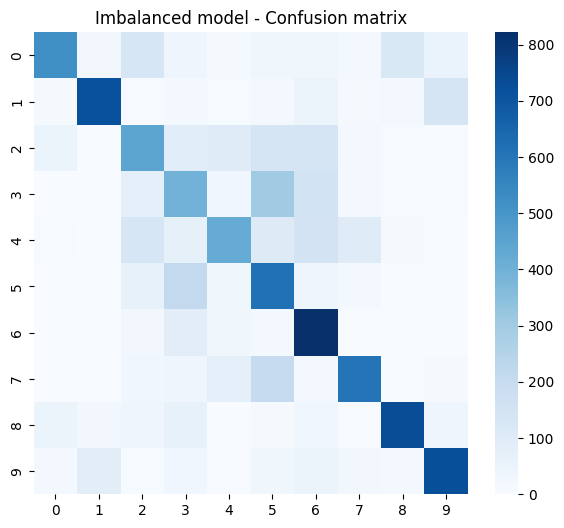

In [13]:
# 10) Train & evaluate - Imbalanced (use class weights)
print("\n=== TRAIN: Imbalanced dataset (demo, 8 epochs) ===")
tf.keras.backend.clear_session()
model_imb = build_tiny_hlga()
model_imb, hist_imb = compile_and_train(model_imb, train_imb_ds, val_ds, class_weights=cw_imb, epochs=8, lr=1e-3, weight_path='imbalanced_model.weights.h5')

print("\n=== EVAL: Imbalanced model on Test ===")
res_imb = evaluate_on_test(model_imb, test_ds)
print("Imbalanced Test Acc: {:.4f}, F1: {:.4f}".format(res_imb['acc'], res_imb['f1']))
plt.figure(figsize=(7,6)); sns.heatmap(res_imb['cm'], cmap='Blues'); plt.title('Imbalanced model - Confusion matrix'); plt.show()

True label index: 6


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_image']]
Received: inputs=['Tensor(shape=(1, 32, 32, 3))']
  warnings.warn(msg)


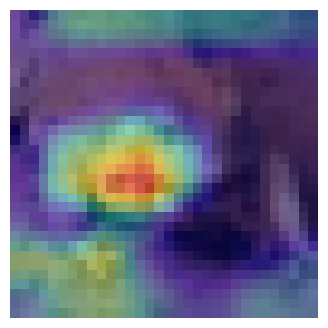

In [16]:
# 11) Small Grad-CAM example (for the balanced model) - visualize last conv layer activations
def make_gradcam_heatmap(model, img_tensor, class_index, last_conv_layer_name='conv3'):
    # model: our Keras model
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    img = tf.expand_dims(img_tensor, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img)
        loss = preds[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-9)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (32,32))
    return tf.squeeze(heatmap).numpy()

def show_cam_on_image(img, heatmap, alpha=0.4):
    import cv2
    img_uint8 = np.uint8(255*img)
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap)[:, :, :3])
    overlay = cv2.addWeighted(img_uint8, 1-alpha, heatmap_rgb, alpha, 0)
    plt.figure(figsize=(4,4)); plt.imshow(overlay); plt.axis('off'); plt.show()

# pick a test image
sample_img = x_test[5]   # change index if you want a different image
sample_label = y_test[5]
print("True label index:", sample_label)
heatmap = make_gradcam_heatmap(model_bal, sample_img, int(sample_label), last_conv_layer_name='conv3')
show_cam_on_image(sample_img, heatmap)